In [1]:

import os
import pandas as pd
# import train_model
# import generate_synthetic
# import train_classifier
# import test_imgs
import numpy as np
import torch
from datetime import datetime
import os
import logging
from datetime import datetime
from random import seed

import split_dataset as split
import train_model
import cnn_classifier

In [2]:

path_home = '/home/pathorad3090/Documents/Hadar/SyntheticEvaluation'
path_models = path_home + "/models"
path_raw_data = path_home + "/data/mnist_images"
path_cnn_classifier = path_home + '/cnn_classifier'

print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # To use to cuda GPU


True
1


In [3]:

# Set parameters for which train_size, gen_size, synthetic/real ratio, GAN train cutoff
# Set initial dir for experiments

# Set parameters as lists of integer values
seed = 42
train_sizes = [50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000]  # List of different training sizes
gen_sizes = [50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000]  # List of different generation sizes
synthetic_real_ratio = 0.5  # Ratio of synthetic to real data
gan_train_cutoff = 5000  # Number of GAN training iterations before switching
train_ratio = 0.8
kimg = 500
# Configure logging
timestamp = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
log_filename = (f"log_{timestamp}_seed{seed}_trainSizes{'_'.join(map(str, train_sizes))}_"
                f"genSizes{'_'.join(map(str, gen_sizes))}_kimg{kimg}.log")

logging.basicConfig(    filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
# Example log messages
logging.info('Logging setup complete.')
logging.info('Parameters used: seed=%d, train_sizes=%s, gen_sizes=%s, kimg=%d', seed, train_sizes, gen_sizes, kimg)

# Log the configured parameters for verification
logger.info('log_filename: '+ log_filename)
logger.info("Training Configuration:")
logger.info(f"Train Sizes: {train_sizes}")
logger.info(f"Generation Sizes: {gen_sizes}")
# logger.info(f"Synthetic/Real Ratio: {synthetic_real_ratio}")
# logger.info(f"StyleGAN2-ADA Training Cutoff: {gan_train_cutoff}")
# logger.info(f"Train Ratio: {train_ratio}")
logger.info(f"Train Cutoff: {kimg}")
logger.info("-" * 40)  # Separator for clarity


2024-11-08 23:59:08,813 - INFO - Logging setup complete.
2024-11-08 23:59:08,814 - INFO - Parameters used: seed=42, train_sizes=[50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000], gen_sizes=[50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000], kimg=500
2024-11-08 23:59:08,814 - INFO - log_filename: log_2024_11_08__23_59_08_seed42_trainSizes50_100_400_800_1000_5000_10000_25000_50000_genSizes50_100_400_800_1000_5000_10000_25000_50000_kimg500.log
2024-11-08 23:59:08,815 - INFO - Training Configuration:
2024-11-08 23:59:08,815 - INFO - Train Sizes: [50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000]
2024-11-08 23:59:08,815 - INFO - Generation Sizes: [50, 100, 400, 800, 1000, 5000, 10000, 25000, 50000]
2024-11-08 23:59:08,815 - INFO - Train Cutoff: 500
2024-11-08 23:59:08,816 - INFO - ----------------------------------------


In [4]:
# Use preprocessing.ipynb to create a proper dataset
# Distribute files to relevant subfolders + create JSON


In [5]:
# Define paths and parameters
full_json = path_home + '/data/dataset_full.json'
path_train_json = full_json

logger.info(f"Loading data from {full_json} for splitting into train/test subsets.")

# Split into train/test subsets
train_df, test_df = split.split_train_test(path_train_json, train_ratio, seed=seed)

path_train_json = f"{path_raw_data}/train_data.json"
path_test_json = f"{path_raw_data}/test_data.json"

logger.info(f"Saving training data to {path_train_json}.")
split.save_json_dataset(train_df, path_train_json)

logger.info(f"Saving testing data to {path_test_json}.")
split.save_json_dataset(test_df, path_test_json)

logger.info("Printing class distribution for training and testing datasets.")
split.print_class_distribution(train_df, "Train")
split.print_class_distribution(test_df, "Test")

logger.info("Data splitting and saving completed successfully.")


2024-11-08 23:59:08,829 - INFO - Loading data from /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/dataset_full.json for splitting into train/test subsets.
2024-11-08 23:59:08,829 - INFO - Splitting data from /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/dataset_full.json with train ratio: 0.8
Splitting data: 100%|██████████| 10/10 [00:00<00:00, 98.80class/s]
2024-11-08 23:59:08,969 - INFO - Split completed: 47995 training samples and 12005 testing samples.
2024-11-08 23:59:08,973 - INFO - Saving training data to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images/train_data.json.
2024-11-08 23:59:08,973 - INFO - Saving data to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images/train_data.json
2024-11-08 23:59:09,036 - INFO - Data saved successfully: /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images/train_data.json
2024-11-08 23:59:09,038 - INFO - Saving testing data to /home/pathorad3090/Docume

In [6]:
# !export MKL_SERVICE_FORCE_INTEL=1

In [7]:
# create classifier dataset to train

path_test_json = path_test_json
path_train_json = path_train_json
test_size = 500


logger.info(f"Creating directories for test files: {path_cnn_classifier} json with size: {test_size}")
# _, _, path_model_images = split.open_folders(model_name, path_cnn_classifier)
path_classifier_data = path_cnn_classifier + "/data"
path_classifier_train = os.path.join(path_classifier_data,'train')
path_classifier_val = os.path.join(path_classifier_data,'val')
os.makedirs(path_cnn_classifier, exist_ok=True)
os.makedirs(path_classifier_data, exist_ok=True)
os.makedirs(path_classifier_train, exist_ok=True)
os.makedirs(path_classifier_val, exist_ok=True)



cnn_train_df = pd.read_json(path_train_json)
cnn_val_df = pd.read_json(path_test_json)
# print(cnn_train_df['labels'])
cnn_train_df = pd.DataFrame(cnn_train_df['labels'].tolist(), columns=['file_path', 'label'])
cnn_val_df = pd.DataFrame(cnn_val_df['labels'].tolist(), columns=['file_path', 'label'])



logger.info(f"Subset DataFrame created. Path raw data: {path_raw_data}, Path classifier data: {path_classifier_data}")
split.copy_images_to_model_and_dataset(cnn_train_df, path_raw_data, path_classifier_train)
split.copy_images_to_model_and_dataset(cnn_val_df, path_raw_data, path_classifier_val)


logger.info(f"Saving subset data to {path_cnn_classifier}")
split.save_json_dataset(cnn_train_df, path_cnn_classifier + "/dataset_train.json")
split.save_json_dataset(cnn_val_df, path_cnn_classifier + "/dataset_test.json")


logger.info(f"Distributing files into label directories at {path_classifier_data}")
split.distribute_files_to_label_dirs(path_classifier_train)
split.distribute_files_to_label_dirs(path_classifier_val)


logger.info("Generating labels JSON for the subset.")
split.generate_labels_json(path_classifier_train, path_classifier_train, "dataset.json")
split.generate_labels_json(path_classifier_val, path_classifier_val, "dataset.json")


2024-11-08 23:59:09,073 - INFO - Creating directories for test files: /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier json with size: 500
2024-11-08 23:59:09,134 - INFO - Subset DataFrame created. Path raw data: /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images, Path classifier data: /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier/data
2024-11-08 23:59:09,135 - INFO - Copying images from /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier/data/train
2024-11-08 23:59:11,784 - INFO - Copying images from /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/data/mnist_images to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier/data/val
2024-11-08 23:59:12,494 - INFO - Saving subset data to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier
2024-11-08 23:59:12,494 - INFO - Saving data to /hom

In [8]:
# train_dir = ??
# val_dir = ??


# Define paths to training and validation directories
train_dir = path_classifier_train
val_dir = path_classifier_val

# Set device for training (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoader objects using create_dataloaders function from cnn.py
batch_size = 100
train_loader, val_loader = cnn_classifier.create_dataloaders(train_dir, val_dir, batch_size)

# Initialize the LeNet model
model = cnn_classifier.LeNet().to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model using train_model function from cnn.py
epochs = 3
running_loss_history, running_corrects_history, val_running_loss_history, val_running_corrects_history = cnn_classifier.train_model(
    model, criterion, optimizer, train_loader, val_loader, epochs, device
)



Epoch 1/3
Train Loss: 0.6641, Train Accuracy: 81.8708
Val Loss: 0.2653, Val Accuracy: 91.8200
Epoch 2/3
Train Loss: 0.1976, Train Accuracy: 94.2521
Val Loss: 0.1521, Val Accuracy: 95.5000
Epoch 3/3
Train Loss: 0.1306, Train Accuracy: 96.0521
Val Loss: 0.1117, Val Accuracy: 96.9000


[tensor(81.8708, device='cuda:0'), tensor(94.2521, device='cuda:0'), tensor(96.0521, device='cuda:0')]
[tensor(91.8200, device='cuda:0'), tensor(95.5000, device='cuda:0'), tensor(96.9000, device='cuda:0')]
[0.664115802012384, 0.19762779693119228, 0.1306118492386304]
[0.2653072074055672, 0.15209526404738427, 0.1116885582357645]


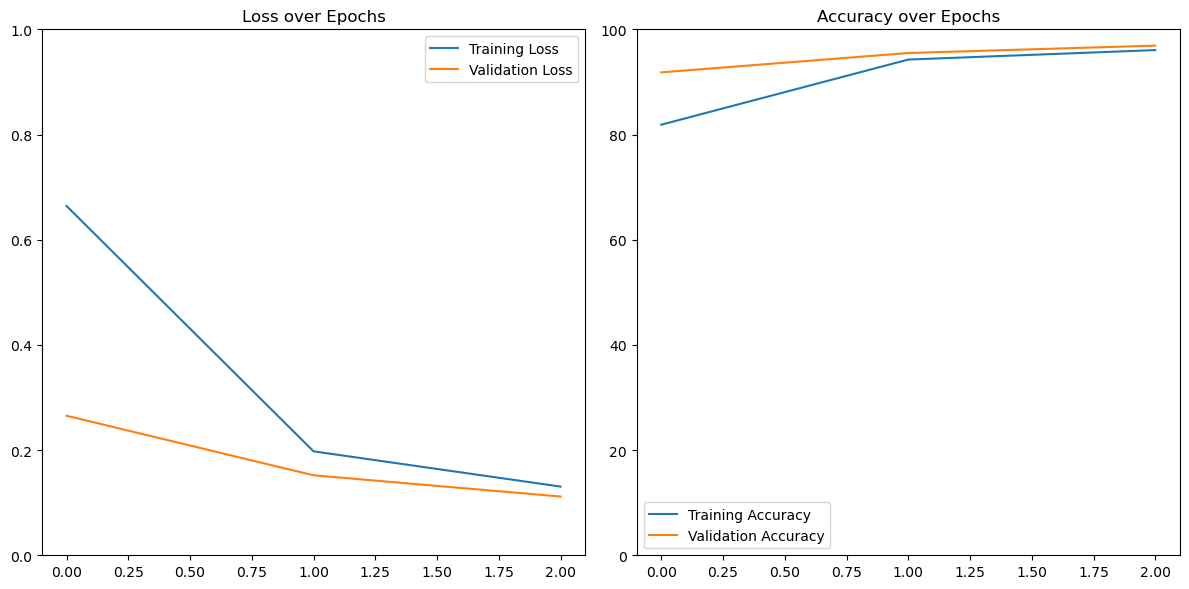

Model saved to /home/pathorad3090/Documents/Hadar/SyntheticEvaluation/cnn_classifier/model.pth


In [9]:
print(running_corrects_history)
print(val_running_corrects_history)
print(running_loss_history)
print(val_running_loss_history)

running_corrects_history_cpu = [x.cpu().item() for x in running_corrects_history]
val_running_corrects_history_cpu = [x.cpu().item() for x in val_running_corrects_history]
# running_loss_history_cpu = [x.cpu().item() for x in running_loss_history]
# val_running_loss_history_cpu = [x.cpu().item() for x in val_running_loss_history]
# Plot the training and validation loss/accuracy over epochs using plot_results function from cnn.py
cnn_classifier.plot_results(running_loss_history, val_running_loss_history,running_corrects_history_cpu, val_running_corrects_history_cpu)

# Optionally save the model after training
model_save_path = path_cnn_classifier+'/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')



In [ ]:
# train MLP/CNN classifier, test for benchmark using test_imgs.py


In [ ]:
# train_json = path_raw_data + '/train_data.json'
path_curr_run = os.path.join(path_models, 'run_' + datetime.now().strftime('%Y%m%d_%H-%M'))
# train_sizes = [40000]

for train_size in train_sizes:
    # Create a name for the subset and the model
    model_name = f"model_{train_size}_{datetime.now().strftime('%Y%m%d_%H-%M')}"
    path_model = os.path.join(path_curr_run, model_name)
    path_experiments = os.path.join(path_model, 'experiments')
    path_dataset = os.path.join(path_model, 'dataset')
    path_subset_json = f"{path_model}/dataset_subset_size_{train_size}_seed_{seed}.json"
    
    logger.info(f"Creating directories for model: {model_name}")
    _, _, path_model_images = split.open_folders(model_name, path_model)
    
    logger.info(f"Generating subset data from {path_train_json} with size {train_size} and seed {seed}")
    subset_df = split.subset_data(path_train_json, train_size, seed)
    
    logger.info(f"Subset DataFrame created. Path raw data: {path_raw_data}, Path model images: {path_model_images}")
    split.copy_images_to_model_and_dataset(subset_df, path_raw_data, path_model_images)
    
    logger.info(f"Saving subset data to {path_subset_json}")
    split.save_json_dataset(subset_df, path_subset_json)

    logger.info(f"Distributing files into label directories at {path_model_images}")
    split.distribute_files_to_label_dirs(path_model_images)
    
    logger.info("Generating labels JSON for the subset.")
    split.generate_labels_json(path_model_images, path_model_images, "dataset.json")
    
    logger.info(f"Creating dataset for {model_name}...")
    train_model.create_dataset(path_home, path_model_images, path_dataset)

    logger.info(f"Training model {model_name}...")
    train_model.run_stylegan_training(path_home, path_experiments, path_dataset, snap=10, kimg=kimg)
    
    logger.info(f"Cleaning up model directories for {model_name}")
    # split.delete_images_and_dataset_dirs(path_model)

        
        # train the classifier
        # split the training step and the gen steps


In [ ]:
subset_df
# cnn_train_df

In [ ]:
path_curr_run = os.path.join(path_models, 'run_' + datetime.now().strftime('%Y%m%d_%H-%M'))
path_curr_run = '/home/pathorad3090/Documents/Hadar/SyntheticEvaluation/models'

for entry in os.scandir(path_curr_run):
    if entry.is_dir() and 'model' in str(entry.name):
        print(entry.name)
        path_model = entry
        path_latest_pkl_file = split.get_latest_pkl_file(path_model)
        if path_latest_pkl_file:
            logger.info(f"Most recent .pkl file: {path_latest_pkl_file}")
            for gen_size in gen_sizes:
                gen_size = gen_size // 10
                path_generations = os.path.join(path_model, 'generations_'+ str(gen_size * 10))
                logger.info(f"Generating synthetic images for {entry.name} with generation size {gen_size * 10}...")
                train_model.generate_stylegan_images(path_home, path_latest_pkl_file, path_generations, f"0-{gen_size}")
        else:
            logger.warning("No .pkl file found for generation.")

In [ ]:
path_curr_run = os.path.join(path_models, 'run_' + datetime.now().strftime('%Y%m%d_%H-%M'))
path_curr_run = '/home/pathorad3090/Documents/Hadar/SyntheticEvaluation/models'

for entry in os.scandir(path_curr_run):
    if entry.is_dir() and 'model' in str(entry.name):
        print(entry.name)
        


In [ ]:
# show results - relevant metric: avg/class accuracy, f1, precision, recall, AUC-ROC...
# graph/tabular
logging.shutdown()

